Load modules

In [1]:
#---- Tensorflow ----#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

#--- Visualize ----#
import matplotlib.pyplot as plt
import seaborn as sns

Download Fashion Mnist data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Hyper parameter

In [3]:
n_epoch = 10
batch_size = 32
lr = 1e-3

Look up dataset

In [4]:
# Train : 60000장의 이미지와 라벨
print(f'shape of train image : {train_images.shape}')
print(f'shape of test image : {test_images.shape}')

# Test : 10000장의 이미자와 라벨
print(f'shape of train labels : {train_labels.shape}')
print(f'shape of train labels : {test_labels.shape}')

# Image has value 0~255 
sample_img, sample_label = train_images[0], train_labels[0]
print(f'Max : {np.max(sample_img)}')
print(f'Min : {np.min(sample_img)}')

# Sample 
print(f'sample image shape : {sample_img.shape}')
print(f'sample image shape : {sample_label.shape}')

shape of train image : (60000, 28, 28)
shape of test image : (10000, 28, 28)
shape of train labels : (60000,)
shape of train labels : (10000,)
Max : 255
Min : 0
sample image shape : (28, 28)
sample image shape : ()


In [5]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]
img_size = 28
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Visualize

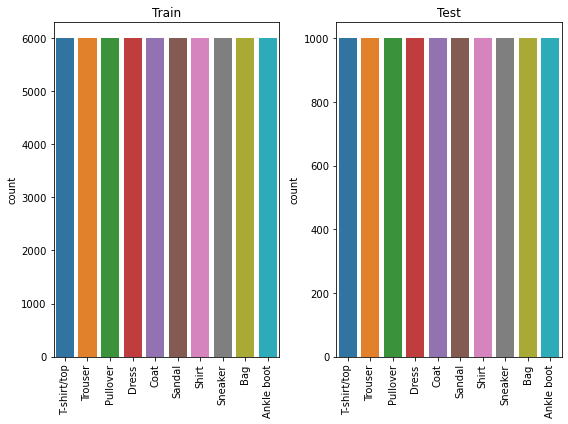

In [6]:
plt.figure(figsize = (8, 6))
plt.subplot(1, 2, 1)
sns.countplot(train_labels)
plt.xticks(list(range(len(class_names))), class_names, 
          rotation = 90)
plt.title('Train')
plt.subplot(1, 2, 2)
sns.countplot(test_labels)
plt.xticks(list(range(len(class_names))), class_names, 
          rotation = 90)
plt.title('Test')
plt.tight_layout()
plt.show()

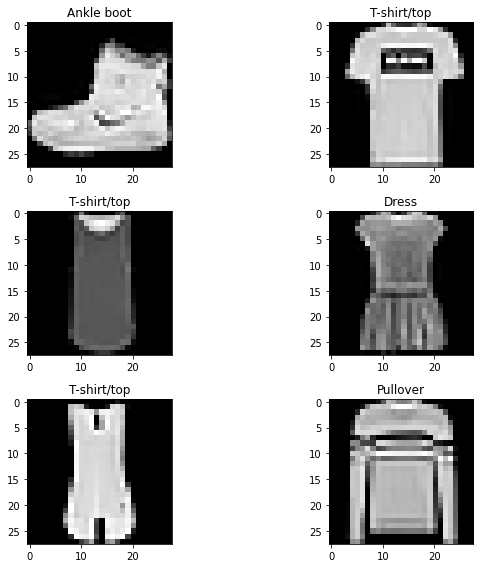

In [7]:
n_row = 3
fig, ax = plt.subplots(n_row,2, figsize = (10, 8))
for i in range(2*n_row):
    sample_img, sample_label = train_images[i], train_labels[i]
    label_name = class_names[sample_label]
    ax[i//2][i%2].imshow(sample_img, cmap = 'gray')
    ax[i//2][i%2].set_title(label_name)
plt.tight_layout()
plt.show()

Preprocessing

In [8]:
# Reshape
# 채널을 만들어 주기 위해 차원 확장
train_images = train_images.reshape((n_train, img_size,
                                    img_size, -1))
test_images = test_images.reshape((n_test, img_size, 
                                  img_size, -1))

Set Data Generator

--- usage ----

    ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        brightness_range=None,
        shear_range=0.0,
        zoom_range=0.0,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=False,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0,
        dtype=None,
    )

In [9]:
train_gen = ImageDataGenerator(rotation_range = 20,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    horizontal_flip = True,
                                   rescale = 1./255.)
test_gen = ImageDataGenerator(rescale = 1./255.)

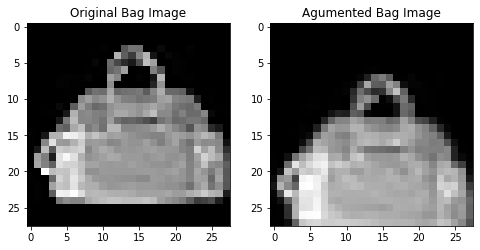

In [10]:
sample_img, sample_label = train_images[1221], train_labels[1221]
agumented_img_iter = train_gen.flow(sample_img[tf.newaxis,:,:,:])
agumented_img = next(iter(agumented_img_iter))
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(np.squeeze(sample_img), cmap = 'gray')
ax[0].set_title(f'Original {class_names[sample_label]} Image')
ax[1].imshow(np.squeeze(agumented_img), cmap = 'gray')
ax[1].set_title(f'Agumented {class_names[sample_label]} Image')
plt.show()

In [11]:
# Generator
train_ds = train_gen.flow(x = train_images,
                          y = train_labels,
                          shuffle = True,
                          batch_size = batch_size,
                         seed = 1221)
test_ds = test_gen.flow(x = test_images,
                        y = test_labels,
                        shuffle = False,
                        batch_size = batch_size,
                        seed = 1221)

Modeling

- Vanilla CNN

In [12]:
class CNN(tf.keras.Model):
    def __init__(self, image_size = (28, 28, 1), n_class = 10,
                 n_channel = 32, n_unit = 1024, n_conv_block = 3,
                kernel_size = (3,3), pool_size = (2,2), activation = 'relu'):
        super(CNN, self).__init__()
        
        #---- Arguments ----#
        self.image_size = image_size
        self.n_class = n_class
        self.n_channel = n_channel
        self.n_unit = n_unit
        self.kernel_size = kernel_size
        self.n_conv_block = n_conv_block
        self.pool_size = pool_size
        self.activation = activation
        
        #---- Dense layers ----#
        self.flat = layers.Flatten()
        self.input_layer = layers.Input(self.image_size)
        self.dense1 = layers.Dense(self.n_unit, activation=self.activation)
        self.dense2 = layers.Dense(self.n_class, activation='softmax')

        #---- Convolution layers ----#
        self.conv_layers = []
        self.activations = []
        self.poolings = []
        for i in range(1, self.n_conv_block+1):
            self.conv_layers.append(layers.Conv2D(self.n_channel*i,
                                                  self.kernel_size,
                                                  padding = 'same'))
            self.activations.append(layers.Activation(self.activation))
            self.poolings.append(layers.MaxPooling2D(self.pool_size))
        
    
    def call(self, x, training = None, mask = None):
        for conv, act, pool in zip(self.conv_layers, self.activations, self.poolings):
            x = pool(act(conv(x)))
        x = self.flat(x)
        x = self.dense1(x)
        return self.dense2(x)
    
model = CNN()

Compile

- Optimizer : Adam

- Loss : Categorical CE

- Metric : Accuracy

In [13]:
model.compile(optimizer = keras.optimizers.Adam(lr),
             loss = keras.losses.sparse_categorical_crossentropy,
             metrics = ['accuracy'])

Training

In [14]:
history = model.fit_generator(train_ds,
                             steps_per_epoch = len(train_ds),
                             epochs = n_epoch,
                             validation_data = test_ds,
                             validation_steps = len(test_ds))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.7224 - accuracy: 0.7241 - val_loss: 0.4877 - val_accuracy: 0.8131
Epoch 2/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.5039 - accuracy: 0.8110 - val_loss: 0.4426 - val_accuracy: 0.8346
Epoch 3/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.4321 - accuracy: 0.8362 - val_loss: 0.4296 - val_accuracy: 0.8458
Epoch 4/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.4010 - accuracy: 0.8497 - val_loss: 0.3702 - val_accuracy: 0.8663
Epoch 5/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.3802 - accuracy: 0.8572 - val_loss: 0.3447 - val_accuracy: 0.8752
Epoch 6/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.3631 - accuracy: 0.8639 - val_loss: 0.3363 - val_accuracy: 0.8798
Epoch 7/10
1875/1875 [==========================

Evaluation

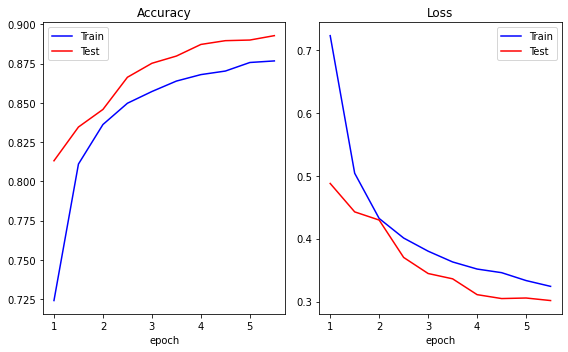

In [15]:
fig, ax = plt.subplots(1, 2, figsize= (8, 5))
ax[0].set_title('Accuracy')
ax[0].plot(history.history['accuracy'], label = 'Train', c = 'b')
ax[0].plot(history.history['val_accuracy'], label= 'Test', c = 'r')
ax[0].legend(loc = 'best')
ax[0].set_xlabel('epoch')
ax[0].set_xticklabels(list(range(n_epoch+1)))

ax[1].set_title('Loss')
ax[1].plot(history.history['loss'], label = 'Train', c = 'b')
ax[1].plot(history.history['val_loss'], label= 'Test', c = 'r')
ax[1].legend(loc = 'best')
ax[1].set_xlabel('epoch')
ax[1].set_xticklabels(list(range(n_epoch+1)))

plt.tight_layout()
plt.show()